## Text Embeddings

In [1]:
%pip install -U sentence-transformers datasets --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import random
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("jinaai/negation-dataset", split="test")


# Get a random index
random_int = random.randint(0, len(dataset))

query = dataset['entailment'][random_int]
docs = dataset['anchor']

/Users/tunji/.local/share/virtualenvs/huggingface-tasks-cFDsNJ9-/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sentence_transformers import SentenceTransformer, util

#Load the model
model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')

#Encode query and documents
query_emb = model.encode(query)
doc_emb = model.encode(docs)

#Compute dot score between query and all document embeddings
scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()

#Combine docs & scores
doc_score_pairs = list(zip(docs, scores))

#Sort by decreasing score
doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

#Output passages & scores
print("Query:", query)
for doc, score in doc_score_pairs:
    print(score, doc)


Query: Two men with a toy.
168.37379455566406 Two men are standing in a boat.
168.245849609375 Two men and a Frisbee
168.12156677246094 Two guys walking, one carrying a skateboard
167.71914672851562 A young boy holding a red toy wearing green snowman and reindeer pajamas with an older woman on a couch behind him.
167.37220764160156 A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.
167.17884826660156 A young boy sits outside in a grassy field with his back turned towards the viewer- he is holding a wooden toy that can be spun between your hands and launched into the air.
167.09710693359375 A young man holds a hammer shaped object in the air with one hand and a similar shaped object in the other while making a funny expression.
167.05392456054688 two dogs fighting over a pink and red toy
166.67041015625 Two men climbing on a wooden scaffold.
166.00772094726562 Two men working on farm equipment that is being pulled by two horses.


## Image Embedding

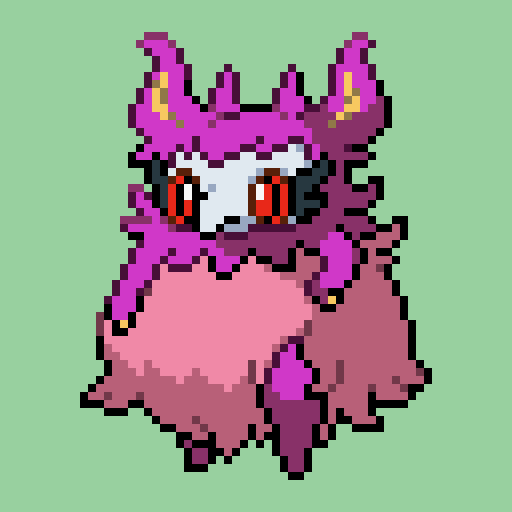

In [18]:
import random
from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoModel

# Load the dataset
dataset = load_dataset("inmortalkaktus/pokemon-pixel-art", split="train")

random_idx = random.randint(0, len(dataset))

query = dataset['image'][random_idx]

query

In [19]:
# Load model for computing embeddings of the candidate images
model_ckpt='google/vit-base-patch16-224'
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/Users/tunji/.local/share/virtualenvs/huggingface-tasks-cFDsNJ9-/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def extract_embeddings(image, extractor, model):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [21]:
dataset_with_embeddings = dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"].convert('RGB'), extractor, model)})

Map: 100%|██████████| 49/49 [00:06<00:00,  7.38 examples/s]


In [22]:
# Get the embeddings of the query image
query_emb = extract_embeddings(query.convert('RGB'), extractor, model)

# Compute the dot score between the query and all the candidate images
scores = util.dot_score(query_emb, dataset_with_embeddings['embeddings'])[0].cpu().tolist()

# Combine images & scores

image_score_pairs = list(zip(dataset['image'], scores))

# Sort by decreasing score
image_score_pairs = sorted(image_score_pairs, key=lambda x: x[1], reverse=True)

# Output images & scores
for img, score in image_score_pairs[:2]:
    print(score)
    img.show()

667.1354370117188


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


420.53485107421875


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
